# Predictions corrections

### table of content
1) [Load samples](#load-samples)
2) [Metrics](#metrics)
3) [Performances computation](#performances-computation)

### Dependencies and general utils

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import open3d as o3d
import laspy
import pdal
import json
import pickle
from tqdm import tqdm
from scipy.spatial import cKDTree
from time import time

### Load samples

In [23]:
src_preds = r"..\..\data\flattening_corrections\predictions"
src_gt = r"..\..\data\flattening_corrections\gt"
src_floors = r"..\..\data\flattening_corrections\floors"
src_masks = r"..\..\data\flattening_corrections\masks"
src_originals = r"..\..\data\flattening_corrections\originals"
src_flatten = r"..\..\data\flattening_corrections\flatten"
src_results = r"..\..\data\flattening_corrections"

In [25]:
list_preds = {}
list_masks = {}
list_floors = {}
list_flatten = {}
list_floors = {}
list_gt = {}
list_originals = {}

samples_num = [128, 129, 160, 210, 311, 633]
tilling_num = [0, 1, 5, 10, 20]
for r, _, f in os.walk(src_preds):
    for num in samples_num:
        list_preds[num] = [os.path.join(r, file) for file in f if len(file.split(str(num))) > 1]
for r, _, f in os.walk(src_masks):
    for num in samples_num:
        list_masks[num] = [os.path.join(r, file) for file in f if len(file.split(str(num))) > 1]
for r, _, f in os.walk(src_floors):
    for num in samples_num:
        list_floors[num] = [os.path.join(r, file) for file in f if len(file.split(str(num))) > 1]
for r, _, f in os.walk(src_flatten):
    for num in samples_num:
        list_flatten[num] = [os.path.join(r, file) for file in f if len(file.split(str(num))) > 1]
for r, _, f in os.walk(src_originals):
    for num in samples_num:
        list_originals[num] = [os.path.join(r, file) for file in f if len(file.split(str(num))) > 1][0]
for r, _, f in os.walk(src_gt):
    for num in samples_num:
        list_gt[num] = [os.path.join(r, file) for file in f if len(file.split(str(num))) > 1][0]


### Metrics

In [4]:
def compute_panoptic_quality(gt_instances, pred_instances):
    """
    Computes Panoptic Quality (PQ), Segmentation Quality (SQ), and Recognition Quality (RQ).
    
    :param gt_instances: List of sets, each containing point indices for a ground truth instance.
    :param pred_instances: List of sets, each containing point indices for a predicted instance.
    :return: PQ, SQ, RQ
    """

    # gt_instances, pred_instances = get_segmentation(gt_instances, pred_instances)
    tp, fp, fn = 0, 0, 0
    iou_sum = 0

    # Match predicted instances to ground truth instances
    matched_gt = set()
    matched_pred = set()
    
    for i, gt in enumerate(gt_instances):
        best_iou = 0
        best_pred = None

        for j, pred in enumerate(pred_instances):
            iou = len(gt & pred) / len(gt | pred)  # IoU computation
            
            if iou > best_iou:
                best_iou = iou
                best_pred = j
        
        # Threshold for a valid match
        if best_iou > 0.5:
            matched_gt.add(i)
            matched_pred.add(best_pred)
            tp += 1
            iou_sum += best_iou
        else:
            fn += 1  # Unmatched ground truth instance
    
    fp = len(pred_instances) - len(matched_pred)  # Unmatched predictions

    RQ = tp / (tp + 0.5 * (fp + fn)) if (tp + 0.5 * (fp + fn)) > 0 else 0
    SQ = iou_sum / tp if tp > 0 else 0
    PQ = SQ * RQ

    return PQ, SQ, RQ, tp, fp, fn


def compute_mean_iou(y_true, y_pred, num_classes=2):
    """
    Computes mean Intersection over Union (mIoU).
    
    :param y_true: Ground truth labels (N,)
    :param y_pred: Predicted labels (N,)
    :param num_classes: Total number of classes
    :return: Mean IoU score
    """
    iou_list = []
    
    for c in range(num_classes):
        tp = np.sum((y_true == c) & (y_pred == c))
        fp = np.sum((y_true != c) & (y_pred == c))
        fn = np.sum((y_true == c) & (y_pred != c))
        
        iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
        iou_list.append(iou)

    return np.mean(iou_list)


def get_segmentation(instance_list, semantic_list):
    instances_format = []
    semantic_format = []
    # Computing instances
    for instance in set(instance_list):
        if instance == 0: continue
        list_points = [pos for pos, val in enumerate(instance_list) if val == instance]
        instances_format.append(set(list_points))

    # Computing semantic
    for semantic in set(semantic_list):
        list_points = [pos for pos, val in enumerate(semantic_list) if val == semantic]
        semantic_format.append(set(list_points))

    return instances_format, semantic_format


### Performances computation

#### Utils

In [5]:
def remove_duplicates(laz_file):
    # Find pairs of points
    coords = np.round(np.vstack((laz_file.x, laz_file.y, laz_file.z)),2).T
    tree_B = cKDTree(coords)
    pairs = tree_B.query_pairs(1e-2)

    # Create the mask with dupplicates
    mask = [True for i in range(len(coords))]
    for pair in pairs:
        mask[pair[1]] = False

    # Remove the dupplicates from the file
    laz_file.points = laz_file.points[mask]


def match_pointclouds(laz1, laz2):
    """Sort laz2 to match the order of laz1 without changing laz1's order.

    Args:
        laz1: laspy.LasData object (reference order)
        laz2: laspy.LasData object (to be sorted)
    
    Returns:
        laz2 sorted to match laz1
    """
    # Retrieve and round coordinates for robust matching
    coords_1 = np.round(np.vstack((laz1.x, laz1.y, laz1.z)), 2).T
    coords_2 = np.round(np.vstack((laz2.x, laz2.y, laz2.z)), 2).T

    # Verify laz2 is of the same size as laz1
    assert len(coords_2) == len(coords_1), "laz2 should be a subset of laz1"

    # Create a dictionary mapping from coordinates to indices
    coord_to_idx = {tuple(coord): idx for idx, coord in enumerate(coords_1)}

    # Find indices in laz1 that correspond to laz2
    matching_indices = []
    failed = 0
    for coord in coords_2:
        try:
            matching_indices.append(coord_to_idx[tuple(coord)])
        except Exception as e:
            failed += 1
    # print(f"Number of non-matching points: {failed}")

    matching_indices = np.array([coord_to_idx[tuple(coord)] for coord in coords_2])

    # Sort laz2 to match laz1
    sorted_indices = np.argsort(matching_indices)

    # Apply sorting to all attributes of laz2
    laz2.points = laz2.points[sorted_indices]

    return laz2  # Now sorted to match laz1


#### Computing on all samples

In [27]:
import copy
import pickle
metrics = ['PQ', 'SQ', 'RQ', 'mIoU', 'Recall', 'Precision']
metrics_res = {samp_num: np.zeros((len(samples_num), len(tilling_num))) for samp_num in samples_num}

for i, samp_num in tqdm(enumerate(samples_num), total=len(samples_num)):
    original_src = list_originals[samp_num]
    gt_src = list_gt[samp_num]
    laz_original = laspy.read(original_src)

    for j, tilling in enumerate(tilling_num):
        if tilling > 0:
            pred_src = [x for x in list_preds[samp_num] if len(x.split(f'{tilling}m')) > 1][0]
            floor_src = [x for x in list_floors[samp_num] if len(x.split(f'{tilling}m')) > 1][0]
            flatten_src = [x for x in list_flatten[samp_num] if len(x.split(f'{tilling}m')) > 1][0]
            mask_src = [x for x in list_masks[samp_num] if len(x.split(f'{tilling}m')) > 1][0]
        else:
            pred_src = [x for x in list_preds[samp_num] if len(os.path.basename(x).split('flatten')) == 1][0]
            flatten_src = original_src

        laz_pred = laspy.read(pred_src)
        laz_gt = laspy.read(gt_src)
        laz_flatten = laspy.read(flatten_src)

        laz_pred = match_pointclouds(laz_flatten, laz_pred)

        pred_coords = np.vstack((laz_pred.x, laz_pred.y, laz_pred.z)).T
        gt_coords = np.vstack((laz_gt.x, laz_gt.y, laz_gt.z)).T

        remove_duplicates(laz_gt)
        laz_gt = match_pointclouds(laz_original, laz_gt)

        # Crop groud truth
        if len(os.path.basename(pred_src).split('flatten')) > 1:
            # add floor to preds
            laz_floor = laspy.read(floor_src)
            floor_coords = np.vstack((laz_floor.x, laz_floor.y, laz_floor.z)).T
            pred_coords[:,2] = pred_coords[:,2] + floor_coords[:,2]
            setattr(laz_pred, 'x', pred_coords[:,0])
            setattr(laz_pred, 'y', pred_coords[:,1])
            setattr(laz_pred, 'z', pred_coords[:,2])

            # load mask
            with open(mask_src, 'rb') as infile:
                mask = pickle.load(infile)
            laz_gt.points = laz_gt.points[mask]
            laz_gt = match_pointclouds(laz_pred, laz_gt)

        # Compute metrics
        gt_instances = laz_gt.gt_instance_segmentation
        gt_semantic = laz_gt.gt_semantic_segmentation
        pred_instances = laz_pred.PredInstance
        pred_semantic = laz_pred.PredSemantic

        gt_instances_format, gt_semantic_format = get_segmentation(gt_instances, gt_semantic)
        pred_instances_format, pred_semantic_format = get_segmentation(pred_instances, pred_semantic)
        
        PQ, SQ, RQ, tp, fp, fn = compute_panoptic_quality(gt_instances_format, pred_instances_format)
        mean_iou = compute_mean_iou(gt_semantic, pred_semantic)
        metrics_res[samp_num][0,j] = PQ
        metrics_res[samp_num][1,j] = SQ
        metrics_res[samp_num][2,j] = RQ
        metrics_res[samp_num][3,j] = mean_iou
        metrics_res[samp_num][4,j] = round(tp/(tp + fn), 2) if tp + fn > 0 else 0
        metrics_res[samp_num][5,j] = round(tp/(tp + fp),2) if tp + fp > 0 else 0
    

100%|██████████| 6/6 [04:33<00:00, 45.58s/it]


In [28]:
for metric in metrics_res.keys():
    print(metric)
    print(metrics_res[metric])

128
[[0.34065424 0.27893734 0.34397479 0.30623971 0.3653979 ]
 [0.8913786  0.85424559 0.87904667 0.90034476 0.89944099]
 [0.38216561 0.32653061 0.39130435 0.34013605 0.40625   ]
 [0.60604914 0.63191958 0.63392697 0.63583162 0.65339008]
 [0.83       0.67       0.84       0.78       0.84      ]
 [0.25       0.22       0.25       0.22       0.27      ]]
129
[[0.00879969 0.01545159 0.00774913 0.0076665  0.        ]
 [0.65704315 0.64896697 0.68967276 0.69765143 0.        ]
 [0.01339286 0.02380952 0.01123596 0.01098901 0.        ]
 [0.29553193 0.35938154 0.3375126  0.32546136 0.3116106 ]
 [0.43       0.43       0.29       0.4        0.        ]
 [0.01       0.01       0.01       0.01       0.        ]]
160
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.33496977 0.45848743 0.45757023 0.44668689 0.47684911]
 [0.         0.         0.         0.         0.        ]


### Visualization

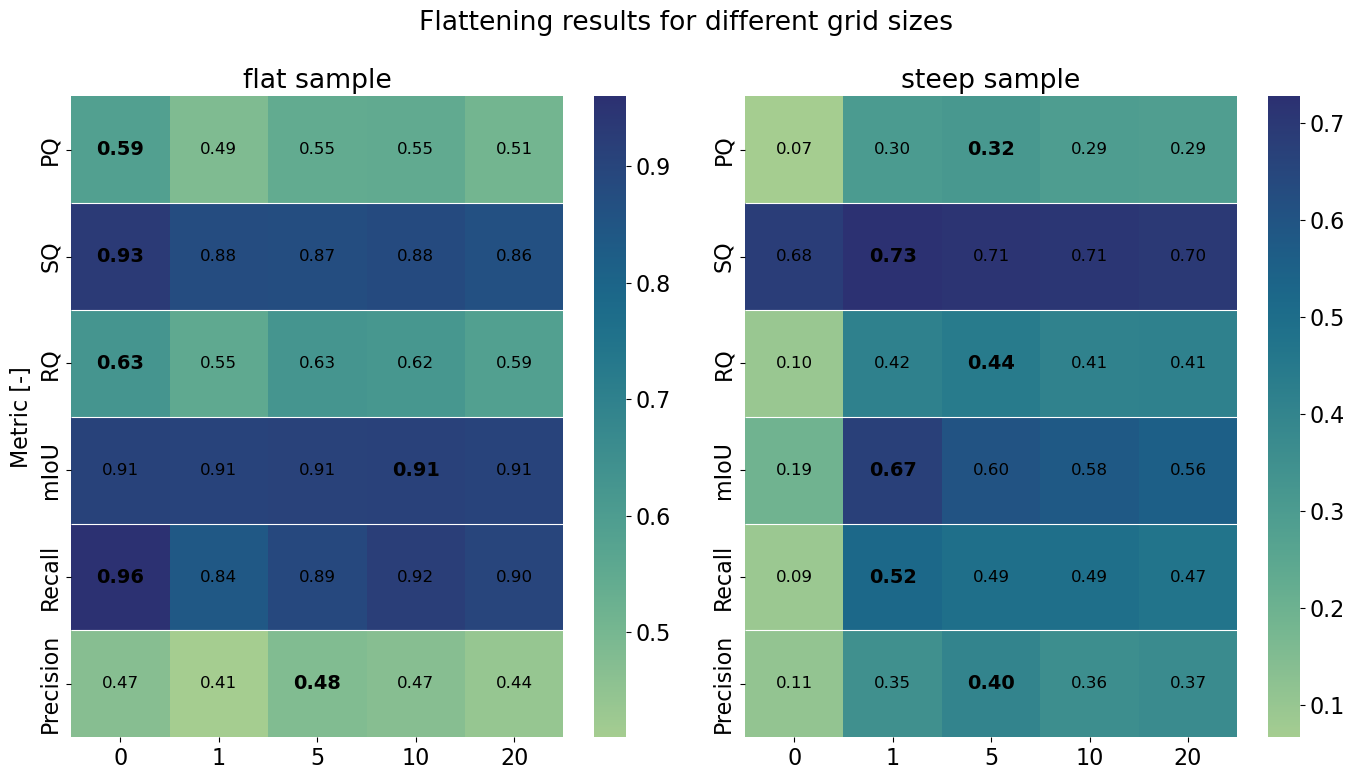

In [41]:
src_location = r"C:\Users\swann\Documents\EPFL\Master\PDM_admin\medias\flattening"
dict_sampnum_to_terrain = {
    # 128: "light slope sample",
    # 129: "bushes sample",
    # 160: "slope empty sample",
    # 210: "flat empty sample",
    311: "flat sample",
    633: "steep sample"
}
# plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(1, 2, figsize=(14, 8))
for pos, samp_num in enumerate([311, 633]):
    i = 0
    j = pos%3
    arr_res = metrics_res[samp_num]
    df_data = pd.DataFrame(
        data=arr_res,
        columns=tilling_num,
        index=metrics
    )
    max_mask = df_data.eq(df_data.max(axis=1), axis=0)
    annot_colors = np.full(df_data.shape, "black", dtype=object)  # Default text color
    annot_colors[max_mask] = "red"  # Set highest values to red

    sns.heatmap(data=df_data, cmap="crest", annot=True, ax=axs[j], fmt=".2f")
    axs[j].set_title(dict_sampnum_to_terrain[samp_num])

    # Draw only horizontal grid lines
    axs[j].hlines(np.arange(1, df_data.shape[0]), *axs[j].get_xlim(), color="white", linewidth=0.8)

    # Color the highest values in red
    for text, (k, l) in zip(axs[j].texts, np.ndindex(df_data.shape)):
        text.set_color('black')
        if max_mask.iat[k, l]:  
            text.set_fontsize(14)  # Set the highest value in each row to red
            text.set_fontweight('bold')  # Set the highest value in each row to red
        else:
            text.set_fontsize(12)  # Default color
    if i == 1:
        axs[j].set_xlabel('Grid size [m]')
    if j == 0:
        axs[j].set_ylabel('Metric [-]')
plt.suptitle("Flattening results for different grid sizes")
plt.tight_layout()
plt.savefig(os.path.join(src_location, 'flattening_different_tiling.png'))
plt.savefig(os.path.join(src_location, 'flattening_different_tiling.eps'), format='eps')